# Introduction
In this notebook we are going to load some data, preprocess the data so it is in a suitable format for machine learning, and then fit and evaluate a machine learning model. More specifically, we are going to:
1. Use the `pandas` package to load our (predictive) Analytics Base Table (ABT) `.csv` data
2. Use the `sklearn.preprocessing` package to preprocess the descriptive features in the ABT
3. Use the `LogisticRegression` class to train (A.K.A. "fit") a logistic regression model
4. Use the `sklearn.metrics` package to evaluate the performance of the model

Let's begin by loading in the required packages, along with `matplotlib` and `plotnine` for creating some visualisations.

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from plotnine import *
pd.set_option('mode.chained_assignment',None)
import json

# Data Collection
Let's collect the ABT directly from the GitHub repo.

In [2]:
data_repo_url = "https://github.com/data-analytics-in-business/gabor-firm-exit-case-study/raw/main/data/"
data_file = "sample_2012_ABT.csv"
ABT = pd.read_csv(data_repo_url+data_file)
ABT.head()

,log_sales,p+l_scaled,ind_cat,default
0,7.093159,-8.951987,3,0
1,13.943477,9.182272,2,0
2,7.932070,-7.758650,3,1
3,12.980031,11.479915,3,0
4,11.773208,-7.763383,3,0


# Data Preprocessing
Before we can pass our data to a machine learning algorithm, we need to preprcoess the data so that it is in a suitable format. How we preprocess the data will vary depending on the type of data.

First, let's split out ABT into a target feature `y` and descriptive features `X`.

In [3]:
y = ABT['default']
X = ABT.drop(columns=['default'])

Now let's split our descriptive features (`X`) into those that are *numeric* (`X_num`) and those that are *categorical* (`X_cat`), and preprocess them accordingly.

In [4]:
X_num = X[['log_sales','p+l_scaled']]
X_cat = X['ind_cat'].values.reshape(-1, 1)

**Note**: We use the `.reshape(-1, 1)` method to ensure `X_cat` is the correct shape. This is something we need to do when preprocessing a one-dimensional feature array.

## Preprocessing numeric features
To preprocess the numeric variables, we are going to use the `MinMaxScaler` [class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to scale each numeric feature to be in the range `(0,1)`. Let's create an instance of `MinMaxScaler` and then `fit` and `transform` in one step. Finally, we are going to convert `X_num_scaled` back into a `DataFrame` and `describe` it so we can see the preprocessing step has worked properly.

In [5]:
minmax_scaler = MinMaxScaler()
X_num_scaled = minmax_scaler.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns)
X_num_scaled.describe()

,log_sales,p+l_scaled
count,21723.000000,21723.000000
mean,0.412989,0.514362
std,0.185791,0.266175
min,0.000000,0.000000
25%,0.289106,0.237396
50%,0.405245,0.625309
75%,0.528688,0.765611
max,1.000000,1.000000


## Preprocessing categorical features
To preprocess the categorical variables, we are going to use the `OneHotEncoder` [class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode each categorical feature as a one-hot numeric array. Let's create an instance of `OneHotEncoder` and then `fit` and `transform` in one step. Finally, we are going to convert `X_cat_onehot` back into a `DataFrame` and print the `head` so we can see the preprocessing step has worked properly.

In [6]:
hot_encoder = OneHotEncoder(drop='first', handle_unknown="ignore", sparse=False)
X_cat_onehot = hot_encoder.fit_transform(X_cat)
X_cat_onehot = pd.DataFrame(X_cat_onehot,columns=hot_encoder.get_feature_names_out(['ind_cat']))
X_cat_onehot.head()

,ind_cat_1,ind_cat_2,ind_cat_3
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


## Re-joining numeric and categorical features
Before we train our model, we are going to re-join our (preprocessed) numeric and categorical features into one `X_preprocessed` array of our (processed) descriptive features. Let's print the `head` to check things look OK.

**Note**: We can concatenate (`concat`) them only because the ordering of our rows/examples have not changed. 

In [7]:
X_processed = pd.concat([X_num_scaled, X_cat_onehot], axis=1)
X_processed.head()

,log_sales,p+l_scaled,ind_cat_1,ind_cat_2,ind_cat_3
0,0.020132,0.231099,0.0,0.0,1.0
1,0.763982,0.808822,0.0,1.0,0.0
2,0.111226,0.269116,0.0,0.0,1.0
3,0.659366,0.882020,0.0,0.0,1.0
4,0.528321,0.268965,0.0,0.0,1.0


# Fit model
Now we have preprocessed our features to a suitable format, we can use `X_processed` and `y` to train a machine learning model. Let's create an instance of the `LogisticRegression` [class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and `fit` the model to the training data.

In [8]:
model = LogisticRegression()
model.fit(X_processed,y)

LogisticRegression()

# Evaluate model
Let's now assume that we had this model back in 2012 when the descriptive features were collected, ignoring the fact that we wouldn't have had the data to train the model :)

Refreshing our memories of our application domain, we want to use the model to predict the likelihood a company will default, and then use those probabilities to decide whether to approve a loan or not (assuming one was applied for).

More precisely, we will:
1. Use the model to generate an estimate of the probability that each company will default
2. Threshold the probability values to decide whether to approve a loan or not
3. Compare these decisions to whether the company defaulted in the future or not

Run the code below.

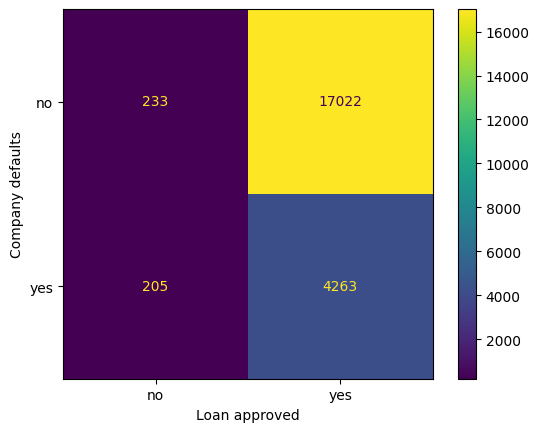

In [9]:
prob_default = model.predict_proba(X_processed)[:, 1]
threshold = 0.5
loan_approved = prob_default < threshold
company_defaults = y

ax= plt.subplot()
ConfusionMatrixDisplay.from_predictions(company_defaults,loan_approved,ax=ax,display_labels=['no','yes'])
ax.set_xlabel('Loan approved')
ax.set_ylabel('Company defaults')
plt.show()

# Exercise
1. Inspect the above visualisation and discuss whether it shows good performance or not.
2. Explore different values for `threshold` and justify some different values.
3. If you have reached this point, return to the original dataset and consider which additional features would be worth incorporating into the model. 